In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "/content/drive/Shareddrives/Unlimited Storage/Plant-CFY.zip" -d "/content/drive/Shareddrives/Unlimited Storage"

In [ ]:
import torch 
import torchvision
import os
import csv
import pandas as pd
from PIL import Image
from torchvision import datasets, transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
import torchvision.transforms as T

import numpy as np
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
data = "/content/drive/Shareddrives/Unlimited Storage/Plant-CFY/data"
train_path = "/content/drive/MyDrive/Colab Notebooks/plant-train.csv"
val_path = "/content/drive/MyDrive/Colab Notebooks/plant-val.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/plant-test.csv"

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def save_checkpoint(state,filename="/content/drive/MyDrive/Colab Notebooks/plantCFY_best_checkpoint.pth.tar"):
  print("==> Saving Checkpoint")
  torch.save(state,filename)
  print("==> Checkpoint Saved")

def load_checkpoint(model,checkpoint):
  print("==> Loading Checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  print("==> Checkpoint Loaded")


In [ ]:
def MakeDataset(path):
  classes=os.listdir(path)
  print(classes)
  ftrain = open(train_path, 'w',newline='')
  wtrain = csv.writer(ftrain)
  wtrain.writerow(['name','class'])

  fval = open(val_path, 'w',newline='')
  wval = csv.writer(fval)
  wval.writerow(['name','class'])

  ftest = open(test_path, 'w',newline='')
  wtest = csv.writer(ftest)
  wtest.writerow(['name','class'])

  for c in range(len(classes)):
    dir=os.listdir(path+"/"+classes[c])
    train,temp= train_test_split(dir, test_size=0.2)
    val,test = train_test_split(temp, test_size=0.5)
    for i in train:
         wtrain.writerow([classes[c]+"/"+i,c])
    for j in val:
         wval.writerow([classes[c]+"/"+j,c])
    for k in test:
         wtest.writerow([classes[c]+"/"+k,c])     
  ftrain.close()
  fval.close()
  ftest.close()

In [ ]:
class GetDataset(Dataset):
    def __init__(self,datapath,csvpath):
        self.datapath=datapath
        self.csvpath=csvpath
        self.df=pd.read_csv(csvpath)
        self.transform=T.Compose([T.Resize(224),T.ToTensor()])
    def __getitem__(self,index):
        self.img=Image.open(self.datapath+'/'+self.df.iloc[index,0])
        self.input=self.transform(self.img)
        self.label=torch.tensor(self.df.iloc[index,1])
        return self.input,self.label
    def __len__(self):
        return len(self.df)

In [ ]:
def LoadDataset(data,train_path,val_path,test_path,batch_size):
  train_ds = GetDataset(data,train_path)
  val_ds = GetDataset(data,val_path)
  test_ds = GetDataset(data,test_path)

  train_loader=DataLoader(train_ds,batch_size,shuffle=True)
  val_loader=DataLoader(val_ds,batch_size,shuffle=True)
  test_loader=DataLoader(test_ds,batch_size,shuffle=False)
  return train_loader,val_loader,test_loader

In [ ]:
def GetModel(no_of_classes,lr):
  model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
  n_inputs = model.fc.in_features
  last_layer = nn.Linear(n_inputs,no_of_classes)
  model.fc= last_layer
  model = model.to(device)
  print("Input Features:",model.fc.in_features)
  print("Output Features:",model.fc.out_features)
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(),lr=lr)
  return model,criterion,optimizer

In [ ]:
def trainer(model,epochs,train_loader,val_loader,criterion,optimizer):
  #Model training and saving best model 
  #load_checkpoint(model,torch.load("/content/drive/MyDrive/Colab Notebooks/plantCFY_best_checkpoint.pth.tar")) 
  epoch_loss=[]
  train_acc=[]
  val_acc=[]
  best_accuracy = 0.0
  for epoch in range(epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_loss=0.0
    train_accuracy=0.0
    val_accuracy=0.0
    len1=0
    len2=0

    loop = tqdm(train_loader)
    for images,labels in loop:
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        optimizer.zero_grad()
        outputs=model(images)
        m = nn.LogSoftmax(dim=1)
        loss=criterion(m(outputs),labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss
        len1 += labels.shape[0]
        prediction=m(outputs).argmax(dim=1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/len1
    train_loss=(train_loss/len1).data.item()
    epoch_loss.append(train_loss)
    train_acc.append(train_accuracy)
    
    
    loop = tqdm(val_loader)  
    
    for images,labels in loop:
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        outputs=model(images)
        len2 += labels.shape[0]
        prediction=m(outputs).argmax(dim=1)
        
        val_accuracy+=int(torch.sum(prediction==labels.data))
        
    val_accuracy=val_accuracy/len2
    val_acc.append(val_accuracy)

    print('\nEpoch:'+str(epoch+1)+' Train Loss: '+str(round(train_loss,5))+' Train Accuracy: '+str(round(train_accuracy,5))+' Val Accuracy: '+str(round(val_accuracy,5)))

    if val_accuracy>=best_accuracy:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)
        best_accuracy=val_accuracy

  return epoch_loss,train_acc,val_acc


In [ ]:
# Evaluation on testing dataset
def tester(model,test_loader):
  model.eval()
  test_accuracy=0.0
  len2=0
  loop1 = tqdm(test_loader)
  for i, (images,labels) in enumerate(loop1):
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        outputs=model(images)
        m = nn.LogSoftmax(dim=1)
        prediction=m(outputs).argmax(dim=1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        len2 += labels.shape[0]
    
  test_accuracy=test_accuracy/len2
  print('\n\n********************************************************************************')
  print('\n Test Accuracy: '+str(round(test_accuracy,5)))
  print('\n********************************************************************************\n\n')

In [ ]:
def plotgraphs(epochs,epoch_loss,train_acc,val_acc):
  plt.figure(figsize=[20,6])
  plt.subplot(121)
  plt.plot(range(epochs),epoch_loss,label='Train Loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Epoch loss')
  plt.title('Loss Curve')
  plt.subplot(122)
  plt.plot(range(epochs),train_acc,color='red',label='Train Accuracy')
  plt.plot(range(epochs),val_acc,color='blue',label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy vs Validation Accuracy')

In [ ]:
def main():
  lr=0.0001
  epochs = 10
  no_of_classes = 12
  batch_size=32
  MakeDataset(data)
  train_loader,val_loader,test_loader=LoadDataset(data,train_path,val_path,test_path,batch_size)
  model,criterion,optimizer = GetModel(no_of_classes,lr)
  epoch_loss,train_acc,val_acc= trainer(model,epochs,train_loader,val_loader,criterion,optimizer)
  tester(model,test_loader)
  plotgraphs(epochs,epoch_loss,train_acc,val_acc)

['Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet', 'Black-grass', 'Charlock']
Input Features: 2048
Output Features: 12


100%|██████████| 15/15 [04:22<00:00, 17.48s/it]



Epoch:1 Train Loss: 0.03877 Train Accuracy: 0.64866 Val Accuracy: 0.87553
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]



Epoch:2 Train Loss: 0.00725 Train Accuracy: 0.92778 Val Accuracy: 0.90506
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]



Epoch:3 Train Loss: 0.00297 Train Accuracy: 0.97364 Val Accuracy: 0.92194
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]



Epoch:4 Train Loss: 0.00218 Train Accuracy: 0.97997 Val Accuracy: 0.92827
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]



Epoch:5 Train Loss: 0.00151 Train Accuracy: 0.98471 Val Accuracy: 0.9346
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]



Epoch:6 Train Loss: 0.0009 Train Accuracy: 0.99077 Val Accuracy: 0.93249


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]



Epoch:7 Train Loss: 0.00086 Train Accuracy: 0.99104 Val Accuracy: 0.94515
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]



Epoch:8 Train Loss: 0.0009 Train Accuracy: 0.99183 Val Accuracy: 0.94093


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]



Epoch:9 Train Loss: 0.00068 Train Accuracy: 0.99526 Val Accuracy: 0.95781
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]



Epoch:10 Train Loss: 0.00043 Train Accuracy: 0.99684 Val Accuracy: 0.94093


100%|██████████| 16/16 [04:29<00:00, 16.87s/it]




********************************************************************************

 Test Accuracy: 0.96058

********************************************************************************




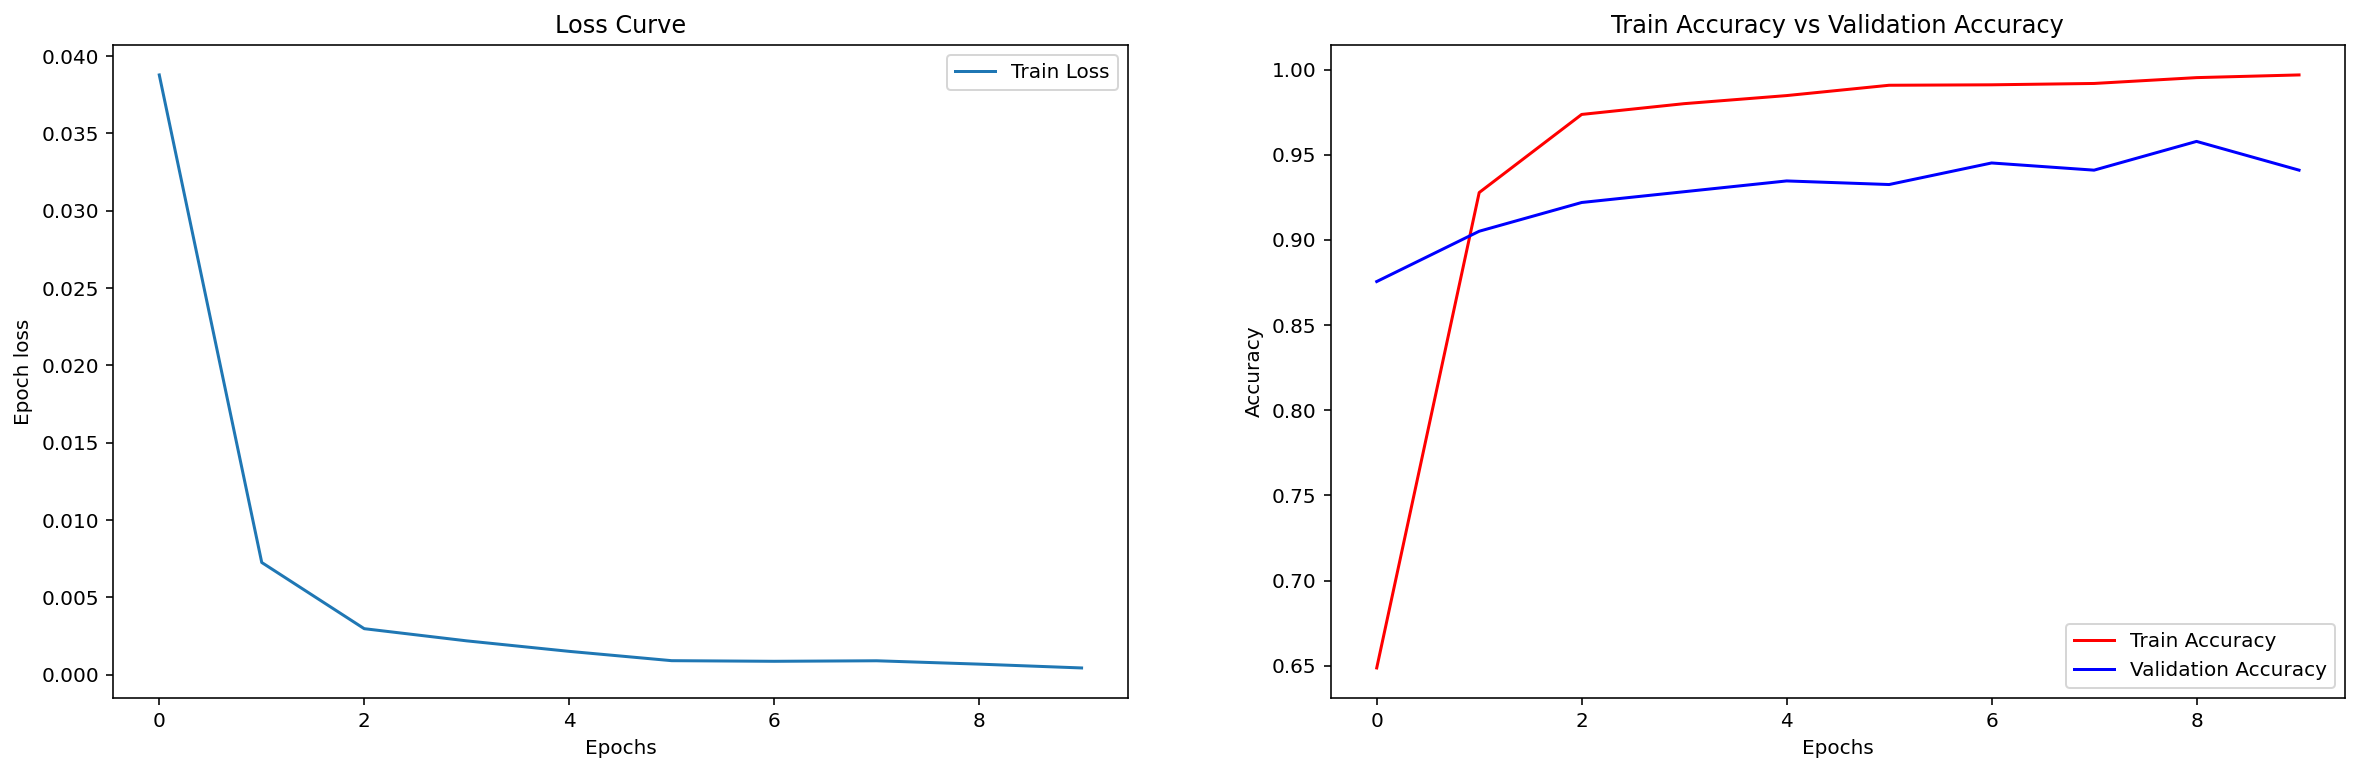

In [ ]:
if __name__ == "__main__":
    main()